# IR1 - Assignment 3
Athanasios Roidis - 11413441 

Nedko Savov - 11404345

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import document
import query
from LambdaRank import LambdaRank
from RankNet import RankNet
from PointwiseRank import PointwiseRank
import numpy
import math
import utils
import matplotlib.pyplot as plt

import theano
theano.config.floatX = 'float32'

## Ranker Implementations

### RankNet Implementation

In order to calculate the gradients, we need to calculate $\lambda_i$ for each document in the query. But in order to do that we first need to calculate the $\lambda_{ij}$ for each document pair $i,j$, when $S_i$ != $S_j$. 

But doing this the naive way, for every possible document pair, this task is going to require $O (|D|^2)$ (double $for$ loop over $i$ and $j$). But if we take into account that $\lambda_{ij} = -\lambda_{ji}$ and that most of the documents are irrelevant, we can reduce this task to  $O (|D_R| \cdot |D_{NR}|)$ (by keeping the outer loop over $i$ on only the relevant documents, and updating $\lambda_{ij}$ and $\lambda_{ji}$ at the same time).

In practise, this means that instead of doing $1000 \cdot 1000$ loops, we can do only $1 \cdot 999$ loops.

After that, we calculate $\lambda_i$ by just taking the sum of the $i$th row on the $\lambda$ matrix.

Finally, for the loss function, we just multiply $\lambda_i$ with the score $s_i$ for each document, and sum the up (instead of the average that the pointwise's implementation had for the mini-batching). That way, we fall in line with

$$ w_k = - \eta \sum_i \lambda_i \frac{s_i}{w_k} $$
since Lasagne is going to find the gradient w.r.t the weights of the network.

### LambdaRank Implementation
For our implementation of LambdaRank we are using the optimizations we already made in RankNet. However, more is needed to make the algorithm fast enough. In LambdaRank, for calculation of every $\lambda_{ij}$ we compare the ranking constructed by the current scores and the same ranking with switched labels for ranks i and j. To avoid recomputing NDCG every time, we use that fact that they differ in just that one pair. When we expand the difference $\Delta_{NDCG}$ we get:
$$\Delta_{NDCG}=\frac{2^{l_i}-2^{l_j}}{maxDCG}(\frac{1}{log(1+i)}+\frac{1}{log(1+i)})$$.

Then, if $i>>j$ (i better than j according to the labels): $$\lambda_{ij}=\frac{1}{1+e^{s_i-s_j}}|\Delta_{NDCG}| = \frac{1}{1+e^{s_i-s_j}} |\frac{(2^{l_i}-2^{l_j})}{maxDCG}(\frac{1}{log(1+i)}+\frac{1}{log(1+i)})|$$. In our implementation, we change the sign of $\lambda_{ij}$, so we take care of changing the optimization direction from minimization to maximization. If $i<<j$: $\lambda_{ij}=-\lambda_{ji}$.
Here, we denote $l_i$, $l_j$ as labels of i and j, and $s_i$, $s_j$ are the scores by the ranker for i and j. This formula allows for dramatic reduction in the computation time for training the ranker.

We calculate maxDCG for a query only once for every epoch.

## Experiments

In [ ]:
#load the dataset
folds = []
for i in range(1, 5+1):
    folds.append(utils.read_queries(i))

In order to improve our rankers, we tried optimizing the neural network's hyperparameters by using cross-validation. We tried different combinations for the number of layers, the hidden units per layer, the activation function, the training algorithm, regularization/momentum and learning rate. 

Unfortunately, none of these significantly improved our results compared to the default setup of 1 layer with 200 hidden units, tanh activation function, adam training and no regularization/momentum. The only thing we use cross-validation for, is to find the best number of training epochs, since after a point the ranker starts overfitting.

### Epoch count optimization

For the cross-validation, when the multiple models (one for each fold) are trained on their training set, they are tested after each epoch on their validation set. The average NDCG@10 at each epoch for each fold is preserved. Then for each number of epochs trained, we average the NDCG@10 over all the folds and we have an NDCG@10 score for every epoch. We finally choose the epoch with the highest score. The models are trained for 25 epochs.

In [55]:
#perform 5-fold cross-validation on all algorithms
#and get results after each of the 25 epochs of every model
ndcgs_pw = utils.crossfold_validation(PointwiseRank, folds, 25)
ndcgs_rn = utils.crossfold_validation(RankNet, folds, 25)
ndcgs_lr = utils.crossfold_validation(LambdaRank, folds, 25)

-------------------------------------------------
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 NDCG: 0.438515
Epoch 2 NDCG: 0.533129
Epoch 3 NDCG: 0.540859
Epoch 4 NDCG: 0.580848
Epoch 5 NDCG: 0.587127
Epoch 6 NDCG: 0.649507
Epoch 7 NDCG: 0.658425
Epoch 8 NDCG: 0.663761
Epoch 9 NDCG: 0.663217
Epoch 10 NDCG: 0.401854
Epoch 11 NDCG: 0.610389
Epoch 12 NDCG: 0.652732
Epoch 13 NDCG: 0.700105
Epoch 14 NDCG: 0.683752
Epoch 15 NDCG: 0.711157
Epoch 16 NDCG: 0.695468
Epoch 17 NDCG: 0.663654
Epoch 18 NDCG: 0.688096
Epoch 19 NDCG: 0.699782
Epoch 20 NDCG: 0.716683
Epoch 21 NDCG: 0.701969
Epoch 22 NDCG: 0.683634
Epoch 23 NDCG: 0.689521
Epoch 24 NDCG: 0.689243
Epoch 25 NDCG: 0.678738
[0.43851479361220758, 0.53312852033854563, 0.54085923875432473, 0.580848231579702, 0.58712710399896217, 0.64950670523813914, 0.65842500919855618, 0.66376088976777559, 0.66321712669539779, 0.40185445710948098, 0.61038855896358701, 0.65273219360971069, 0.70010516015664215, 0.68375230635525219, 0.7111568

In [123]:
#extracting the best epoch count from the cross-validation results
best_epoch_pw = list(ndcgs_pw).index(max(ndcgs_pw))
best_epoch_rn = list(ndcgs_rn).index(max(ndcgs_rn))
best_epoch_lr = list(ndcgs_lr).index(max(ndcgs_lr))
print "Best epoch counts for:"
print " Pointwise:  " + str(best_epoch_pw)
print " RankNet:    " + str(best_epoch_rn)
print " LambdaRank: " + str(best_epoch_lr)

Best epoch counts for:
 Pointwise:  20
 RankNet:    15
 LambdaRank: 22


### Observations

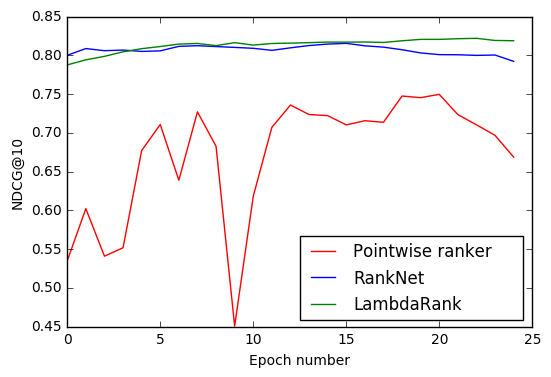

In [105]:
import matplotlib.patches as mpatches
plt.plot(range(0,len(ndcgs_pw)), ndcgs_pw, color="r", label='Pointwise ranker')
plt.plot(range(0,len(ndcgs_rn)), ndcgs_rn, color="b", label='RankNet')
plt.plot(range(0,len(ndcgs_lr)), ndcgs_lr, color="g", label='LambdaRank')
plt.legend(bbox_to_anchor=(0.5, 0.02, 0.48, 0.98), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.ylabel("NDCG@10")
plt.xlabel("Epoch number")
axes = plt.gca()
# axes.set_ylim([0.75, 0.85])
plt.show()

On the plot above it can be seen how each algorithm performed across the number of epochs it was trained on, using NDCG@10 as evaluation metric.

Apart from the information about the best epoch, this plot also can give us insight about how the algorithm compare to each other. It can be seen that Pointwise ranking is generally performing much worse than the other two algorithms. For a better visible comparison between RankNet and LambdaRank, we use the next plot.

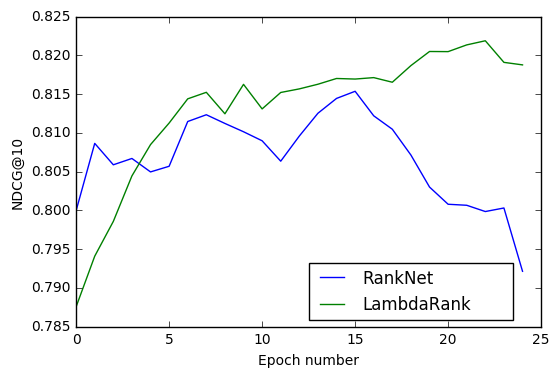

In [108]:
import matplotlib.patches as mpatches
plt.plot(range(0,len(ndcgs_rn)), ndcgs_rn, color="b", label='RankNet')
plt.plot(range(0,len(ndcgs_lr)), ndcgs_lr, color="g", label='LambdaRank')
plt.legend(bbox_to_anchor=(0.5, 0.02, 0.44, 1.02), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.ylabel("NDCG@10")
plt.xlabel("Epoch number")
axes = plt.gca()
# axes.set_ylim([0.75, 0.85])
plt.show()

Here it can be seen that RankNet is generally outperformed by LambdaRank. However, the difference is not large, which raises the question of its statistical significance.

### Comparison

To confirm or reject the mentioned observations, we need to retrain models for each ranking algorithm with its best number of epochs and perform comparison on these models' evaluations on the test set. 

In [58]:
#train a model for each algorithm on the validation and training sets
#and evaluate them on the test sets
eval_pw = utils.evaluate_all(PointwiseRank, folds, best_epoch_pw)
eval_rn = utils.evaluate_all(RankNet, folds, best_epoch_rn)
eval_lr = utils.evaluate_all(LambdaRank, folds, best_epoch_lr)

input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 
Epoch 2 
Epoch 3 
Epoch 4 
Epoch 5 
Epoch 6 
Epoch 7 
Epoch 8 
Epoch 9 
Epoch 10 
Epoch 11 
Epoch 12 
Epoch 13 
Epoch 14 
Epoch 15 
Epoch 16 
Epoch 17 
Epoch 18 
Epoch 19 
Epoch 20 
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 
Epoch 2 
Epoch 3 
Epoch 4 
Epoch 5 
Epoch 6 
Epoch 7 
Epoch 8 
Epoch 9 
Epoch 10 
Epoch 11 
Epoch 12 
Epoch 13 
Epoch 14 
Epoch 15 
Epoch 16 
Epoch 17 
Epoch 18 
Epoch 19 
Epoch 20 
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 
Epoch 2 
Epoch 3 
Epoch 4 
Epoch 5 
Epoch 6 
Epoch 7 
Epoch 8 
Epoch 9 
Epoch 10 
Epoch 11 
Epoch 12 
Epoch 13 
Epoch 14 
Epoch 15 
Epoch 16 
Epoch 17 
Epoch 18 
Epoch 19 
Epoch 20 
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 
Epoch 2 
Epoch 3 
Epoch 4 
Epoch 5 
Epoch 6 
Epoch 7 
Epoch 8 
Epoch 9 
Epoch 10 
Epoch 11 
Epoch 12 
Epoch 13 
Epoch 14 
Epoch 15 
Epoch 16 
Epoch 17 
Epoch 18 
Epoch 19 
Epoch 20 
input_di

In [122]:
mean_pw = numpy.mean([e['all'] for e in eval_pw], axis=0)
mean_rn = numpy.mean([e['all'] for e in eval_rn], axis=0)
mean_lr = numpy.mean([e['all'] for e in eval_lr], axis=0)
means = [mean_pw, mean_rn,mean_lr]

print "Pointwise mean NDCG@10:  " + str(numpy.mean([e['all'] for e in eval_pw], axis=0))
print "RankNet mean NDCG@10:    " + str(numpy.mean([e['all'] for e in eval_rn], axis=0))
print "LambdaRank mean NDCG@10: " + str(numpy.mean([e['all'] for e in eval_lr], axis=0))


Pointwise mean NDCG@10:  0.742037279568
RankNet mean NDCG@10:    0.804109116057
LambdaRank mean NDCG@10: 0.818208968505


On first sight, these results confirm our previous observations - Pointwise is outperformed by RankNet, which is outperformed by LambdaRank. However, we cannot formally confirm that until we perform a statistical significance test.

In order to do the t-test, we store the NDCG@10 of each query of all fold, in a single list. Since we have 30 test queries per fold and 5 folds, this list will have in total 150 queries $^*$. 

With these 150 queries for each one of our 3 rankers (Pointwise, RankNet and LambdaRank) we perform the t-test by comparing them pairwise. But just like in the previous assignment, we must be wary of false rejection of the null hypothesis caused by the multiple comparisons problem, since some of the signicant results we observed might be due to chance. In order to compensate for this, we use the Bonferroni correction, which simply puts a more strict threshold for rejecting the null hypothesis, by dividing the signicance level $\alpha$ with the number of comparison. So in our occasion, if we use $\alpha = 0.05$, it is going to be corrected into $\alpha_c = 0.05/3 = 0.0166$.

$^*$ They are not actually 150, but 146, since we noticed there are some queries with 0 relevant documents and we do not consider them for the comparison, since their NDCG value is invalid (max DCG = 0)

In [112]:
#perform statistical significance on the test set evaluations
results = {}
results["Pointwise"] =utils.get_eval_list(folds, eval_pw)
results["RankNet"] = utils.get_eval_list(folds, eval_rn)
results["LambdaRank"] = utils.get_eval_list(folds, eval_lr)

utils.compute_significance(results)

('Bonferroni corrected alpha:', 0.016666666666666666)


([(('LambdaRank', 'Pointwise'), 3.4247440650345252e-05),
  (('LambdaRank', 'RankNet'), 0.11845995684022738),
  (('Pointwise', 'RankNet'), 0.00093224973371573532)],
 [(('LambdaRank', 'Pointwise'), True),
  (('LambdaRank', 'RankNet'), False),
  (('Pointwise', 'RankNet'), True)])

The results from the t-test can be viewed above. First the p-value for every pair of compared models is shown and then for every pair the result if the models are statistically significant or not are shown.

From the results our observations that the Pointwise ranker is the worst performing is confirmed. However, our claim that LambdaRank is better than RankNet was not proved. The test shows that there is no significant difference between the performance of the implementations of the two algorithms.